# 링크: http://bit.ly/2PeRnl1

# Python 버전 확인 및 OpenCV설치

In [0]:
!python --version

Python 3.6.8


In [0]:
!pip install -U -q PyDrive
!pip install opencv-python==3.4.2.16 && pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 92kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.7.28
    Uninstalling opencv-python-3.4.7.28:
      Successfully uninstalled opencv-python-3.4.7.28
     |████████████████████████████████| 30.6MB 77kB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


# OpenCV 버전 확인

In [0]:
import cv2
cv2.__version__

'3.4.2'

# 실습 이미지 준비

##구글 드라이브 연결
Colab의 현재 세션과 구글 드라이브를 연결하기 위해서 사용한다.

사용방법: 코드 실행시 오른쪽 GDrive_Auth 아래에 생성되는 링크를 타고 구글 로그인을 한뒤에 권한을 수락하고 보이는 코드를 복사하여 링크 아래의 사각형에 붙여넣은 후 엔터를 친다.

In [0]:
#@title GDrive_Auth { vertical-output: true, display-mode: "both" }

# Colab의 현재 세션과 구글 드라이브를 연결하기 위해서 사용한다.
# 파일를 저장하거나 불러오는데 필요하다.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## 이미지 다운로드

In [0]:
# 구글드라이브 공유 링크
link = 'https://drive.google.com/open?id=1yIB3jpCZ3coKF5CF0SNUPsD7kRRguC-a'

# Download image zip file
file3 = drive.CreateFile({'id': link.split('=')[-1]})
print('Downloading file %s from Google Drive' % file3['title'])
file3.GetContentFile(file3['title'])  # Save Drive file as a local file

# 다운받은 이미지 폴더 압축 해제
!unzip -o Archive.zip

Archive:  Archive.zip
   creating: faces/
  inflating: faces/1.png             
  inflating: faces/10.png            
  inflating: faces/11.png            
  inflating: faces/12.png            
  inflating: faces/13.png            
  inflating: faces/14.png            
  inflating: faces/15.png            
  inflating: faces/16.png            
   creating: __MACOSX/
   creating: __MACOSX/faces/
  inflating: __MACOSX/faces/._16.png  
  inflating: faces/17.png            
  inflating: __MACOSX/faces/._17.png  
  inflating: faces/2.png             
  inflating: faces/3.png             
  inflating: faces/4.png             
  inflating: faces/5.png             
  inflating: faces/6.png             
  inflating: faces/7.png             
  inflating: faces/8.png             
  inflating: faces/9.png             
  inflating: detect.png              
  inflating: __MACOSX/._detect.png   
  inflating: sarah.png               
  inflating: __MACOSX/._sarah.png    


## Camera Capture
Webcam을 이용해서 사진을 자신의 사진을 추가할 수 있다.

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import output

def take_photo(filename='Photo.jpg', quality=0.8):
    js = Javascript('''
    
      async function takePhoto(quality) {
          const div = document.createElement('div');
          const captureoff = document.createElement('button');
          captureoff.textContent = 'Capture';
          div.appendChild(captureoff);
          
          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          // Wait for Capture to be clicked.
          await new Promise((reject) => captureoff.onclick = reject);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
        
          canvas.getContext('2d').drawImage(video, 0, 0);

          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
      f.write(binary)
    return filename

In [0]:
from IPython.display import Image
try:
    # take_photo()
    filename = take_photo()
    print('Saved to {}'.format(filename))
    
    # Show the image which was just taken.
    display(Image(filename))
except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

## 얼굴인식 및 저장 


### 사전 정의된 haar-cascade 분류기 다운로드

In [0]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2019-12-02 05:12:01--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.02s   

2019-12-02 05:12:01 (37.6 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



### 얼굴 사진 추가

In [0]:
import cv2
import os
import sys
import numpy as np
from google.colab.patches import cv2_imshow

In [0]:
# 얼굴 찾기
def detectFace(image, cascPath): 
    # Create the haar cascade
    faceCascade = cv2.CascadeClassifier(cascPath)

    detected_img = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,     # 이미지에서 얼굴 크기가 서로 다른 것을 보상해주는 값
        minNeighbors=5,    # 얼굴 사이의 최소 간격(픽셀)입니다
        minSize=(30, 30),   # 얼굴의 최소 크기입니다
    )

    # 검출된 얼굴 주변에 사각형 그리기
    for (x, y, w, h) in faces:
        cv2.rectangle(detected_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    return detected_img, faces



Number: 18 (356, 356, 3)


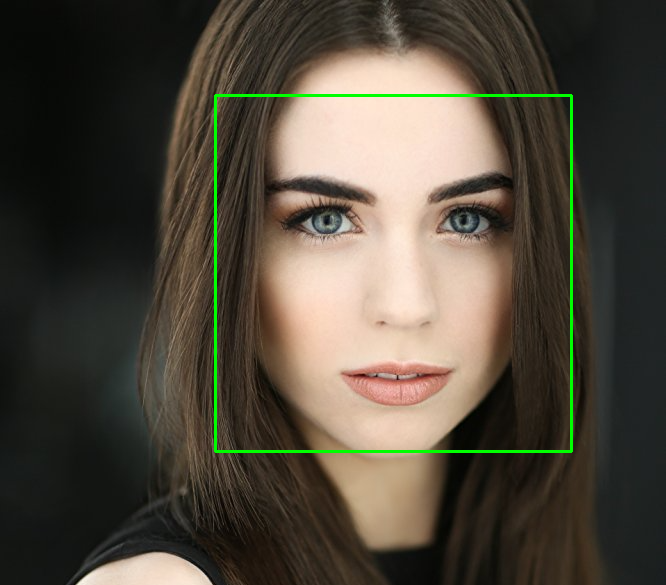

In [0]:
# 이미지 경로 및 필터 경로
imagePath = 'sarah.png'
cascPath = "haarcascade_frontalface_default.xml"

image = cv2.imread(imagePath)

detected_img, faces = detectFace(image, cascPath)

# 데이터베이스에 추가 (검출된 얼굴 Crop 및 저장)
cropped_list = []
start_idx = 18
for i, (x, y, w, h) in enumerate(faces):
    cropped = image[y:y+h, x:x+w, :]
    cropped_list.append(cropped)
    print("Number:", start_idx+i, cropped.shape)
    cv2.imwrite("./faces/"+str(start_idx+i)+".png", cropped)

# 얼굴을 검출한 이미지를 화면에 띄웁니다
cv2_imshow(detected_img)

# EigenFace 만들기

## PCA 계산 방법

1. 평균 얼굴 영상 계산

1. 벡터 공간 만들기 및 벡터공간 정규화

1. 공분산계산

1. eigen_face 계산

1. covariance로 부터 eigenvalue 와 eigenvector 연산

1. 벡터공간에 eigen face 투영

1. DB 저장

In [0]:
def readImages(dir_names):
    file_list = os.listdir("./"+dir_names)
    file_list.sort(key= lambda x: int(x[:-4]))
    
    image_list = []
    for f_name in file_list:
        img = cv2.imread(dir_names+'/'+f_name, 0)
        img = cv2.resize(img, dsize=(32,32))
        img = np.float64(img)
        image_list.append(img)
    return image_list, file_list

In [0]:
# data 매트릭스 생성
def createDataMatrix(images):

    numImages = len(images)
    sz = images[0].shape
    data = np.zeros((numImages, sz[0] * sz[1]), dtype=np.float64)
    for i in range(0, numImages):
        image = images[i].flatten()
        data[i, :] = image
     
    return data

In [0]:
from numpy import linalg as LA

# Directory containing images
dirName = "faces"

# Read images
images, names = readImages(dirName)
 
# Size of images
sz = images[0].shape

# PCA 연산

# 데이터 flattening
data = createDataMatrix(images)

# data의 평균
mean = np.mean(data, axis=0).reshape((1,-1))

# 벡터공간 정규화
vecSpace = data - mean

# 공분산 계산
cov = np.matmul(vecSpace, np.transpose(vecSpace))

# 공분산으로부터 eigenValue 와 eigenVector 계산
w, v = LA.eig(cov) #v[:,i] -> w[i]

# Eigenvector를 정규화된 벡터공간에 투영
eigenFaces = np.matmul(v, vecSpace)

# EigenFaces의 기준 weight
omega = np.matmul(vecSpace, eigenFaces.transpose())

print("DONE")

DONE


## EigenFace Visualization

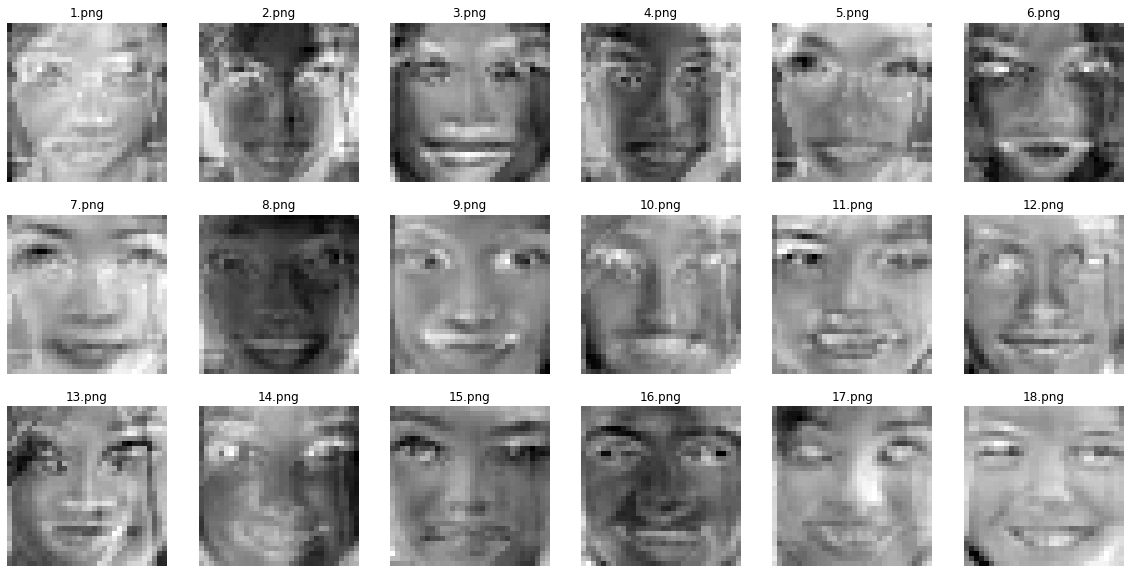

In [0]:
import matplotlib.pyplot as plt
rows = 3
cols = 6
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,10))

for ax in axes.flat:
  ax.axis('off')

for j in range(rows):
  for i in range(cols):
    axes[j,i].imshow(eigenFaces[j*6+i].reshape(sz), cmap='gray')
    axes[j,i].title.set_text(str(j*6+i+1)+".png")

plt.show()

# Face recognition

detection: 18


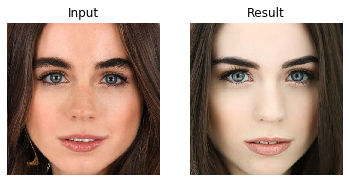

In [0]:
#face recognition

# image 가져오기
f_name = 'detect.png'
img = cv2.imread(f_name)

# image crop
detected_img, faces = detectFace(img, cascPath)

(x, y, w, h) = faces[0]

cropped = img[y:y+h, x:x+w, :]

gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

# crop 영역 리사이즈
resized = cv2.resize(gray, dsize=(32,32))

# 테스트 영상 정규화
flatten_crop = resized.flatten()
test = flatten_crop - mean

# 벡터 공간에 정규화된 테스트영상 투영
proj_test = np.matmul(test, eigenFaces.transpose())

# weight 계산
weight = np.repeat(proj_test, omega.shape[0], axis=0) - omega

# 근접 weight 찾기
dist = np.sqrt(np.sum(weight*weight, axis=1))
minidx = np.argmin(dist)+1

print("detection:", minidx)

# 입력이미지와 출력이미지 비교
result = cv2.imread("faces/"+str(minidx)+".png")
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
input_img = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)

fig = plt.figure()
a = fig.add_subplot(1, 2, 1)

imgplot = plt.imshow(input_img)
a.axis('off')
a.set_title('Input')

a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(result)
a.axis('off')
a.set_title('Result')

plt.show()

# 실습 예제

앞의 코드를 이용하여 자신의 얼굴을 인식하는 인식기 프로그램 작성
